# 서울 시내버스 노선별 정류장별 평균구간운행속도

In [ ]:
import os

import numpy as np
import pandas
import pandas as pd
import geopandas as gpd
import folium

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic", #"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
def read_csv(path):
    df = pd.read_csv(path, encoding='cp949')
    display(df.head())
    print('shape:', df.shape)
    return df

def read_excel(path):
    df = pd.read_excel(path)
    df.columns = df.columns.map(lambda x: x.replace('\n', ''))
    display(df.head())
    print('shape:', df.shape)
    return df

# 1) 데이터 로딩

## a. Geo data

## a. 버스인가현황

In [ ]:
bus_info = read_excel('../../data/서울버스구간별운행속도/시내버스인가현황.xlsx')

,업체명,노선번호,유형,기점,종점,인가대수,운행대수,예비대수,인가거리,운행시간,총운행횟수,최소,최대,첫차시간,막차시간
0,북부운수,1,순환,남산예장버스환승주차장,남산예장버스환승주차장,12,10,2,16.00,60,120,7,10,0630,2300
1,한성여객,100,간선,하계동,용산구청,30,28,2,57.09,231,112,8,12,0400,2230
2,동아운수,101,간선,우이동,서소문,23,22,1,37.81,170,119,5,11,0400,2300
3,한성운수,101,간선,우이동,서소문,9,8,1,37.81,165,41,6,12,0400,2300
4,삼화상운,102,간선,상계주공7단지,동대문,2,2,0,30.20,126,14,8,12,0400,2310


shape: (436, 15)


## a. 노선 마스터

In [ ]:
route_master = read_csv('../../data/서울버스구간별운행속도/서울시노선마스터.csv')

,노선_ID,노선_명칭,노선_유형,거리
0,241461015,김포16A,경기,0.0
1,241461005,김포16-1,경기,0.0
2,241461002,김포16,경기,0.0
3,241449011,양주15-1구파발,경기,0.0
4,241449007,양주15-1막차,경기,0.0


shape: (1274, 4)


## b. 정류장 마스터

In [ ]:
station_master = read_csv('../../data/서울버스구간별운행속도/서울시정류장마스터.csv')

,정류장_ID,정류장_명칭,정류장_유형,정류장_번호,위도,경도,버스도착정보안내기_설치_여부
0,717104358,계수사거리(경유),가상정류장,0.0,126.817473,37.452473,미설치
1,500000288,행사장입구,마을버스,25965.0,126.691556,37.321742,미설치
2,500000287,행사장입구,마을버스,25095.0,126.691728,37.321942,미설치
3,500000286,아남중전기,일반차로,25963.0,126.710485,37.319934,미설치
4,500000285,3Z,일반차로,25964.0,126.707130,37.320566,미설치


shape: (70855, 7)


## c. 노선 정류장 노드 마스터

In [ ]:
route_node_master = read_csv('../../data/서울버스구간별운행속도/서울시노선정류장마스터.csv')

,노선_ID,정류장_ID,링크_구간거리(m),정류장_순서
0,241461015,232000857,193.0,3
1,241461015,232000856,203.0,18
2,241461015,232000855,123.0,2
3,241461015,232000854,177.0,19
4,241461015,232000853,0.0,1


shape: (118180, 4)


## d. 노선별 구간별 운행시간

In [ ]:
trip_time_origin = read_csv('../../data/서울버스구간별운행속도/서울시노선별정류장구간별평균운행시간.csv')

,기준_날짜,노선_ID,출발_정류장_ID,도착_정류장_ID,운행시간,운행시간_00시,운행시간_01시,운행시간_02시,운행시간_03시,운행시간_04시,...,운행시간_16시,운행시간_17시,운행시간_18시,운행시간_19시,운행시간_20시,운행시간_21시,운행시간_22시,운행시간_23시,출발_정류장_순서,도착_정류장_순서
0,20230315,241461015,232000852,232000294,67.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5
1,20230315,241461015,115000320,115000321,388.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,11
2,20230315,241461015,232000857,232000852,33.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,4
3,20230315,241461015,115000321,232000433,50.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,12
4,20230315,241461015,232000841,232000842,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,7


shape: (2138574, 31)


## e. 노선별 구간별 운행횟수

In [ ]:
trip_turn_origin = read_csv('../../data/서울버스구간별운행속도/서울시노선별정류장별총버스운행횟수.csv')

,기준_날짜,노선_ID,정류장_ID,버스운행횟수_일,버스운행횟수_00시,버스운행횟수_01시,버스운행횟수_02시,버스운행횟수_03시,버스운행횟수_04시,버스운행횟수_05시,...,버스운행횟수_15시,버스운행횟수_16시,버스운행횟수_17시,버스운행횟수_18시,버스운행횟수_19시,버스운행횟수_20시,버스운행횟수_21시,버스운행횟수_22시,버스운행횟수_23시,정류장_순서
0,20230315,241461015,232000857.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
1,20230315,241461015,232000855.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,2.0
2,20230315,241461015,232000853.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0
3,20230315,241461015,232000852.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
4,20230315,241461015,232000842.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0


shape: (2257783, 29)


# 2) 전처리

## a. trip_time

In [ ]:
print('bus_info', '=' * 54)
print('노선유형:', bus_info['유형'].unique())
print('순환버스:', sorted(set(bus_info.loc[bus_info['유형'] == '순환', '노선번호'].values)))
print('맞춤버스:', sorted(set(bus_info.loc[bus_info['유형'] == '맞춤', '노선번호'].values)))
print('심야버스:', sorted(set(bus_info.loc[bus_info['유형'] == '심야', '노선번호'].values)))
print()
print('route_master', '=' * 50)
print('노선유형:', route_master['노선_유형'].unique())
print('순환버스:', sorted(set(route_master.loc[route_master['노선_유형'] == '순환', '노선_명칭'].values)))
print('관광버스:', sorted(set(route_master.loc[route_master['노선_유형'] == '관광', '노선_명칭'].values)))
print('야간버스:', sorted(set(route_master.loc[route_master['노선_명칭'].str[0] == 'N', '노선_명칭'].values)))

# 맞춤버스 추가 발견
# 기존: [8002, 8003, 8112, 8221, 8331, 8441, 8541, 8551, 8552, 8761, 8771, 8772, 8774, 8777]
# 추가: [8561, 8762, 8773, 8701, 8101]

bus_info ======================================================
노선유형: ['순환' '간선' '지선' '맞춤' '광역' '심야']
순환버스: [1]
맞춤버스: [8002, 8003, 8112, 8221, 8331, 8441, 8541, 8551, 8552, 8761, 8771, 8772, 8774, 8777]
심야버스: ['N13상계', 'N13송파', 'N15사당', 'N15우이', 'N16도봉', 'N16온수', 'N26강서', 'N26중랑', 'N30', 'N32', 'N34', 'N37송파', 'N37진관', 'N51시흥', 'N51하계', 'N61상계', 'N61양천', 'N62면목', 'N62양천', 'N64강서', 'N64염곡', 'N72', 'N75신림', 'N75진관']

route_master ==================================================
노선유형: ['경기' '인천' '마을' '지선' '간선' '공항' '광역' '순환' '관광']
순환버스: ['01', '01A', '01B', '04', '청와대A01(자율주행)']
관광버스: ['TOUR01', 'TOUR02', 'TOUR03', 'TOUR04', 'TOUR11', 'TOUR12']
야간버스: ['N13', 'N15', 'N16', 'N26', 'N30', 'N31', 'N37', 'N51', 'N61', 'N62', 'N64', 'N65', 'N72', 'N73', 'N75', 'N840', 'N852', 'N876']


In [ ]:
bus_info.loc[bus_info['노선번호'] == '8773']

,업체명,노선번호,유형,기점,종점,인가대수,운행대수,예비대수,인가거리,운행시간,총운행횟수,최소,최대,첫차시간,막차시간


In [ ]:
# 노선마스터와 병합
trip_time = pd.merge(trip_time_origin, route_master, on='노선_ID')
trip_time = trip_time.loc[:, ['기준_날짜', '노선_ID', '노선_명칭', '노선_유형',
                              '출발_정류장_ID', '도착_정류장_ID', '출발_정류장_순서', '도착_정류장_순서',
                              '운행시간_18시', '운행시간_19시', '운행시간_20시', '운행시간_21시']]

# 필요한 버스만 추출
trip_time = trip_time.loc[trip_time['노선_유형'].isin(['지선', '간선'])]
trip_time = trip_time.loc[trip_time['노선_명칭'].str[0] != 'N']
trip_time = trip_time.loc[~((trip_time['운행시간_18시'] == 0) & (trip_time['운행시간_19시'] == 0) & (trip_time['운행시간_20시'] == 0) & (trip_time['운행시간_21시'] == 0))]
trip_time.head()

,기준_날짜,노선_ID,노선_명칭,노선_유형,출발_정류장_ID,도착_정류장_ID,출발_정류장_순서,도착_정류장_순서,운행시간_18시,운행시간_19시,운행시간_20시,운행시간_21시
1087694,20230315,124000039,3323,지선,227000488,124000463,8,9,95.0,92.0,91.0,80.0
1087695,20230315,124000039,3323,지선,227000025,124000329,41,42,143.0,115.0,169.0,167.0
1087696,20230315,124000039,3323,지선,124000190,124000100,22,23,153.0,132.0,157.0,146.0
1087697,20230315,124000039,3323,지선,124000465,124000468,10,11,69.0,70.0,58.0,90.0
1087698,20230315,124000039,3323,지선,124000467,124000466,36,37,50.0,55.0,52.0,48.0


In [ ]:
trip_time

,기준_날짜,노선_ID,노선_명칭,노선_유형,출발_정류장_ID,도착_정류장_ID,출발_정류장_순서,도착_정류장_순서,운행시간_18시,운행시간_19시,운행시간_20시,운행시간_21시
1087694,20230315,124000039,3323,지선,227000488,124000463,8,9,95.0,92.0,91.0,80.0
1087695,20230315,124000039,3323,지선,227000025,124000329,41,42,143.0,115.0,169.0,167.0
1087696,20230315,124000039,3323,지선,124000190,124000100,22,23,153.0,132.0,157.0,146.0
1087697,20230315,124000039,3323,지선,124000465,124000468,10,11,69.0,70.0,58.0,90.0
1087698,20230315,124000039,3323,지선,124000467,124000466,36,37,50.0,55.0,52.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2136307,20230217,100100205,2234,지선,106000329,106000197,21,22,95.0,124.0,75.0,83.0
2136308,20230217,100100205,2234,지선,106000229,106000232,37,38,53.0,54.0,54.0,38.0
2136309,20230217,100100205,2234,지선,106000306,106000304,33,34,48.0,53.0,45.0,47.0
2136310,20230217,100100205,2234,지선,106000195,106000193,23,24,129.0,142.0,110.0,120.0


## b. trip_turn

In [ ]:
trip_turn_origin.isna().sum()

기준_날짜               0
노선_ID               0
정류장_ID          16877
버스운행횟수_일        43199
버스운행횟수_00시    1272204
버스운행횟수_01시    1938518
버스운행횟수_02시    2151731
버스운행횟수_03시    2183535
버스운행횟수_04시    1854070
버스운행횟수_05시    1109174
버스운행횟수_06시     516355
버스운행횟수_07시     329234
버스운행횟수_08시     314757
버스운행횟수_09시     311067
버스운행횟수_10시     321179
버스운행횟수_11시     321429
버스운행횟수_12시     323321
버스운행횟수_13시     328709
버스운행횟수_14시     330728
버스운행횟수_15시     329997
버스운행횟수_16시     333732
버스운행횟수_17시     333846
버스운행횟수_18시     325447
버스운행횟수_19시     306146
버스운행횟수_20시     317046
버스운행횟수_21시     339623
버스운행횟수_22시     369395
버스운행횟수_23시     560152
정류장_순서          20087
dtype: int64

In [ ]:
# 노선마스터와 병합
trip_turn = pd.merge(trip_turn_origin, route_master, on='노선_ID')
trip_turn = trip_turn.loc[:, ['기준_날짜', '노선_ID', '노선_명칭', '노선_유형',
                              '정류장_ID', '정류장_순서',
                              '버스운행횟수_18시', '버스운행횟수_19시', '버스운행횟수_20시', '버스운행횟수_21시']]

# 필요한 버스만 추출
trip_turn = trip_turn.loc[trip_turn['노선_유형'].isin(['지선', '간선'])]
trip_turn = trip_turn.loc[trip_turn['노선_명칭'].str[0] != 'N']
trip_turn = trip_turn.loc[~(np.isnan(trip_turn['버스운행횟수_18시']) & np.isnan(trip_turn['버스운행횟수_19시']) & np.isnan(trip_turn['버스운행횟수_20시']) & np.isnan(trip_turn['버스운행횟수_21시']))]
trip_turn['정류장_ID'] = trip_turn['정류장_ID'].astype('int64')
trip_turn.head()

,기준_날짜,노선_ID,노선_명칭,노선_유형,정류장_ID,정류장_순서,버스운행횟수_18시,버스운행횟수_19시,버스운행횟수_20시,버스운행횟수_21시
1138479,20230315,124000039,3323,지선,227000632,39.0,4.0,4.0,3.0,5.0
1138480,20230315,124000039,3323,지선,227000488,8.0,3.0,4.0,4.0,4.0
1138481,20230315,124000039,3323,지선,227000292,40.0,4.0,4.0,3.0,4.0
1138482,20230315,124000039,3323,지선,227000255,7.0,3.0,4.0,4.0,4.0
1138483,20230315,124000039,3323,지선,227000173,6.0,4.0,3.0,5.0,3.0


In [ ]:
trip_turn.isna().sum()

기준_날짜            0
노선_ID            0
노선_명칭            0
노선_유형            0
정류장_ID           0
정류장_순서           0
버스운행횟수_18시    2374
버스운행횟수_19시    2503
버스운행횟수_20시    2292
버스운행횟수_21시    3125
dtype: int64

In [ ]:
trip_turn_na = trip_turn.loc[trip_turn['버스운행횟수_18시'].isna() | trip_turn['버스운행횟수_19시'].isna() | trip_turn['버스운행횟수_20시'].isna() | trip_turn['버스운행횟수_21시'].isna()]
display(trip_turn_na.head())
print(set(trip_turn_na['노선_명칭'].values))

,기준_날짜,노선_ID,노선_명칭,노선_유형,정류장_ID,정류장_순서,버스운행횟수_18시,버스운행횟수_19시,버스운행횟수_20시,버스운행횟수_21시
1147333,20230224,124000008,7719,지선,112000202,1.0,2.0,2.0,NaN,2.0
1147473,20230220,124000008,7719,지선,112000202,1.0,1.0,1.0,1.0,NaN
1147543,20230218,124000008,7719,지선,112000202,1.0,1.0,NaN,2.0,2.0
1147578,20230217,124000008,7719,지선,112000202,1.0,1.0,1.0,1.0,NaN
1155540,20230311,123000011,708,간선,100000023,33.0,NaN,3.0,1.0,4.0


{'400', '6637', '401', '501', '6649', '1138', '172', '0017', '604', '7025', '771', '8774', '505', '1129', '5713', '405', '750B', '5522A난곡', '6411', '700', '7212', '7016', '7018', '6630', '1711', '7021', '701', '603', '506', '7011', '702B용두초교', '7013A', '105', '8003', '702A서오릉', '109', '653', '571', '704', '421', '202', '1136', '262', '8701', '1141', '472', '151', '5626', '402', '146', '173', '1020', '7613', '5633', '705', '773', '406', '8772', '1221', '101', '652', '150', '674', '8773', '4425', '504', '5627', '502', '8762', '7017', '5625', '103', '152', '7013B', '7719', '605', '8777', '111', '750A', '7022', '500', '708', '100', '1226', '303', '661', '5513'}


In [ ]:
# 운행횟수 결측치 채우기
# 운행횟수는 평균운행시간과 곱해질 값이므로 임의로 추정하게 되면 오차가 크게 발생할 우려가 있음
# 즉, 결측치는 0.0으로 채운다

trip_turn.fillna(0.0, inplace=True)
trip_turn.isna().sum()

기준_날짜         0
노선_ID         0
노선_명칭         0
노선_유형         0
정류장_ID        0
정류장_순서        0
버스운행횟수_18시    0
버스운행횟수_19시    0
버스운행횟수_20시    0
버스운행횟수_21시    0
dtype: int64

# 3) 속도 구하기

## a. 단순하게 접근

- 운행시간(18 ~ 21시)을 직접 평균내기

In [ ]:
trip_time

,기준_날짜,노선_ID,노선_명칭,노선_유형,출발_정류장_ID,도착_정류장_ID,출발_정류장_순서,도착_정류장_순서,운행시간_18시,운행시간_19시,운행시간_20시,운행시간_21시
1087694,20230315,124000039,3323,지선,227000488,124000463,8,9,95.0,92.0,91.0,80.0
1087695,20230315,124000039,3323,지선,227000025,124000329,41,42,143.0,115.0,169.0,167.0
1087696,20230315,124000039,3323,지선,124000190,124000100,22,23,153.0,132.0,157.0,146.0
1087697,20230315,124000039,3323,지선,124000465,124000468,10,11,69.0,70.0,58.0,90.0
1087698,20230315,124000039,3323,지선,124000467,124000466,36,37,50.0,55.0,52.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2136307,20230217,100100205,2234,지선,106000329,106000197,21,22,95.0,124.0,75.0,83.0
2136308,20230217,100100205,2234,지선,106000229,106000232,37,38,53.0,54.0,54.0,38.0
2136309,20230217,100100205,2234,지선,106000306,106000304,33,34,48.0,53.0,45.0,47.0
2136310,20230217,100100205,2234,지선,106000195,106000193,23,24,129.0,142.0,110.0,120.0


In [ ]:
trip_time.shape

(734571, 13)

In [ ]:
# 운행시간 18~21시 평균 계산
trip_time['운행시간_18_21'] = trip_time.loc[:, ['운행시간_18시', '운행시간_19시', '운행시간_20시', '운행시간_21시']].mean(axis=1)

# 노선정류장노드마스터 병합(도착 정류장 기준)
trip_speed = pd.merge(trip_time, route_node_master, left_on=['노선_ID', '도착_정류장_ID', '도착_정류장_순서'], right_on=['노선_ID', '정류장_ID', '정류장_순서'])

# 구간속도(km/h) = 구간거리(m) / 운행시간(s) * 3600/1000
trip_speed['운행속도_18_21'] = trip_speed['링크_구간거리(m)'] / trip_speed['운행시간_18_21'] * 3600/1000
trip_speed.head()

,기준_날짜,노선_ID,노선_명칭,노선_유형,출발_정류장_ID,도착_정류장_ID,출발_정류장_순서,도착_정류장_순서,운행시간_18시,운행시간_19시,운행시간_20시,운행시간_21시,운행시간_18_21,정류장_ID,링크_구간거리(m),정류장_순서,운행속도_18_21
0,20230315,124000039,3323,지선,227000488,124000463,8,9,95.0,92.0,91.0,80.0,89.50,124000463,523.0,9,21.036872
1,20230314,124000039,3323,지선,227000488,124000463,8,9,95.0,98.0,85.0,90.0,92.00,124000463,523.0,9,20.465217
2,20230313,124000039,3323,지선,227000488,124000463,8,9,96.0,99.0,95.0,90.0,95.00,124000463,523.0,9,19.818947
3,20230312,124000039,3323,지선,227000488,124000463,8,9,86.0,95.0,77.0,97.0,88.75,124000463,523.0,9,21.214648
4,20230311,124000039,3323,지선,227000488,124000463,8,9,79.0,89.0,80.0,87.0,83.75,124000463,523.0,9,22.481194


In [ ]:
trip_speed_mean = trip_speed.groupby(by=['노선_ID', '출발_정류장_ID', '도착_정류장_ID', '출발_정류장_순서', '도착_정류장_순서'], as_index=False)['운행속도_18_21'].mean()
trip_speed_mean

,노선_ID,출발_정류장_ID,도착_정류장_ID,출발_정류장_순서,도착_정류장_순서,운행속도_18_21
0,100100006,100000028,100000376,40,41,20.249122
1,100100006,100000147,100000367,30,31,16.929310
2,100100006,100000365,100000397,32,33,17.586918
3,100100006,100000366,105000552,52,53,13.710705
4,100100006,100000367,100000365,31,32,18.059552
...,...,...,...,...,...,...
27718,124000039,227000173,227000255,6,7,18.100268
27719,124000039,227000255,227000488,7,8,8.870447
27720,124000039,227000292,227000025,40,41,16.168319
27721,124000039,227000488,124000463,8,9,20.599651


# 4) 시각화

- 원활: 25km/h 이상
- 서행: 15km/h ~ 25km/h
- 정체: 15km/h 미만
- https://topis.seoul.go.kr/refRoom/openRefRoom_1_3.do

In [ ]:
print(route_master.columns)
print(station_master.columns)

Index(['노선_ID', '노선_명칭', '노선_유형', '거리'], dtype='object')
Index(['정류장_ID', '정류장_명칭', '정류장_유형', '정류장_번호', '위도', '경도', '버스도착정보안내기_설치_여부'], dtype='object')


In [ ]:
merged = trip_speed_mean
merged = pd.merge(merged, route_master, on='노선_ID')
merged = pd.merge(merged, station_master, left_on=['도착_정류장_ID'], right_on=['정류장_ID'])
merged.head()

,노선_ID,출발_정류장_ID,도착_정류장_ID,출발_정류장_순서,도착_정류장_순서,운행속도_18_21,노선_명칭,노선_유형,거리,정류장_ID,정류장_명칭,정류장_유형,정류장_번호,위도,경도,버스도착정보안내기_설치_여부
0,100100006,100000028,100000376,40,41,20.249122,101,간선,37.81,100000376,강북삼성병원,일반차로,1165.0,126.968600,37.568146,미설치
1,100100006,100000147,100000367,30,31,16.929310,101,간선,37.81,100000367,동묘앞,중앙차로,1044.0,127.019672,37.574243,설치
2,100100008,100000147,100000367,24,25,16.844807,103,간선,30.42,100000367,동묘앞,중앙차로,1044.0,127.019672,37.574243,설치
3,100100010,105000485,100000367,32,33,18.099423,105,간선,38.80,100000367,동묘앞,중앙차로,1044.0,127.019672,37.574243,설치
4,100100023,100000147,100000367,28,29,16.925071,144,간선,47.20,100000367,동묘앞,중앙차로,1044.0,127.019672,37.574243,설치


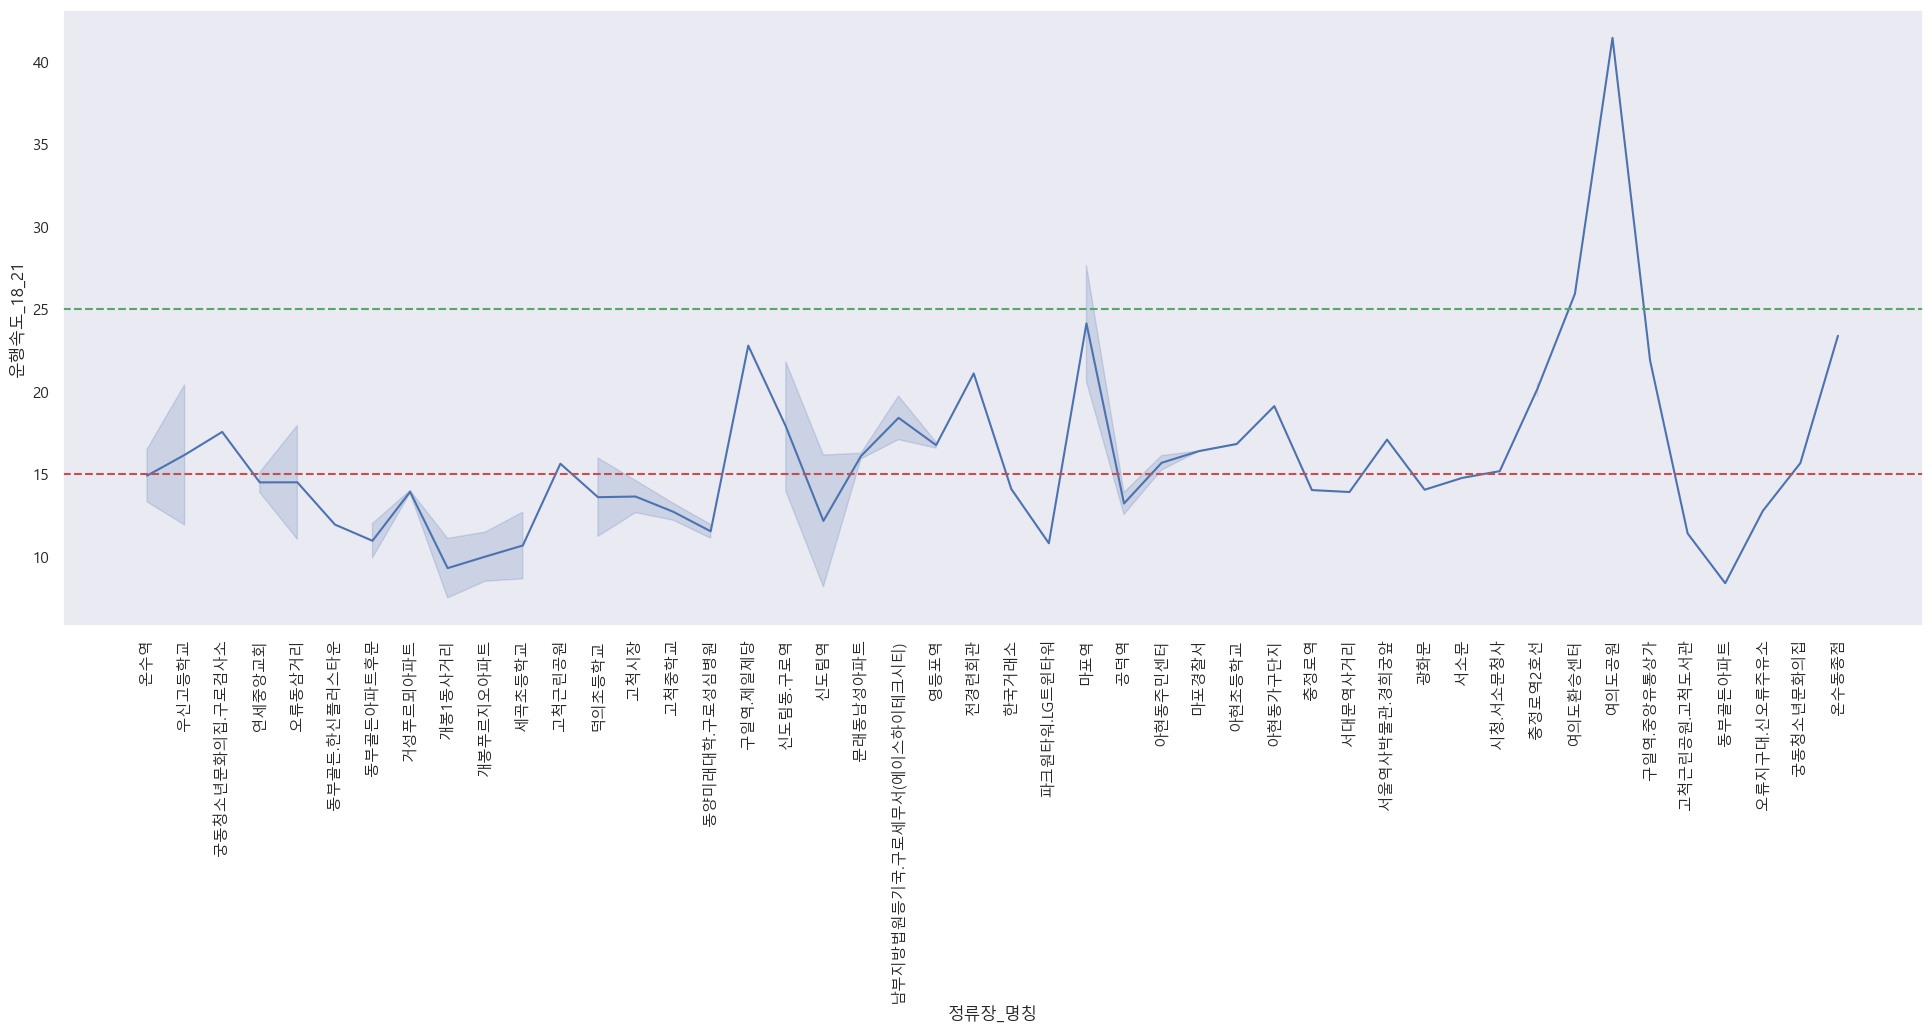

In [ ]:
target_nm = '600'

target = merged.loc[merged['노선_명칭'] == target_nm].copy()
target.sort_values(by='도착_정류장_순서', inplace=True)

plt.figure(figsize=(24, 8))
sns.lineplot(data=target, x='정류장_명칭', y='운행속도_18_21')
plt.axhline(y=25, color='g', linestyle='--')
plt.axhline(y=15, color='r', linestyle='--')
plt.xticks(rotation=90)
plt.grid(visible=False)
plt.show()

In [ ]:
points = list(target.loc[:, ['경도', '위도']].values)
points[:5]

[array([ 37.613523, 127.006248]),
 array([ 37.612294, 127.007986]),
 array([ 37.61157 , 127.008419]),
 array([ 37.608465, 127.009821]),
 array([ 37.605165, 127.011412])]

In [ ]:
m = folium.Map(
    location=[37.56687825320445, 126.97860130760616],
    zoom_start=12,
    tiles='CartoDBpositron'
)

folium.PolyLine(points, color='red', weight=2.5, opacity=1).add_to(m)

# folium.GeoJson(
#     gdf,
#     name='자치구'
# ).add_to(m)

# folium.Choropleth(
#     name='choropleth',
#     # geo_data=gdf,
#     geo_data=None,
#     # data=data,
#     # key_on='feature.id',
#     fill_color='YlOrRd',
#     fill_opacity=0.3,
#     # legend_name='자치구별 이동인구(합)'
# ).add_to(m)

# folium.LayerControl().add_to(m)
# folium.TileLayer().add_to(m)

m